In [1]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

from histaug.data import Kather100k
from histaug.augmentations import load_augmentations
from histaug.utils import rc_context, savefig
from histaug.utils.display import RENAME_AUGMENTATIONS

JOURNAL = True

In [2]:
torch.manual_seed(3)

augmentations = load_augmentations()
# augmentations = load_augmentations(excluded_keys=[])

ds = Kather100k("/data/cache/huggingface")
loader = DataLoader(ds, batch_size=None, shuffle=True, num_workers=0)

# Get an example patch for each class
examples = {}
it = iter(loader)
while not all(c in examples for c in ds.classes):
    img, label, *_ = next(it)
    if ds.classes[label] not in examples:
        examples[ds.classes[label]] = img

2024-05-27 15:44:54.136 | INFO     | histaug.augmentations:__init__:30 - Fitting Macenko normalizer to /app/normalization_template.jpg


/app/histaug/utils/figures.py:20: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(f"{figures_dir}/{name}.pdf", bbox_inches="tight", dpi=DPI)
/app/histaug/utils/figures.py:21: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(f"{figures_dir}/{name}.png", bbox_inches="tight", dpi=DPI)
/app/env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


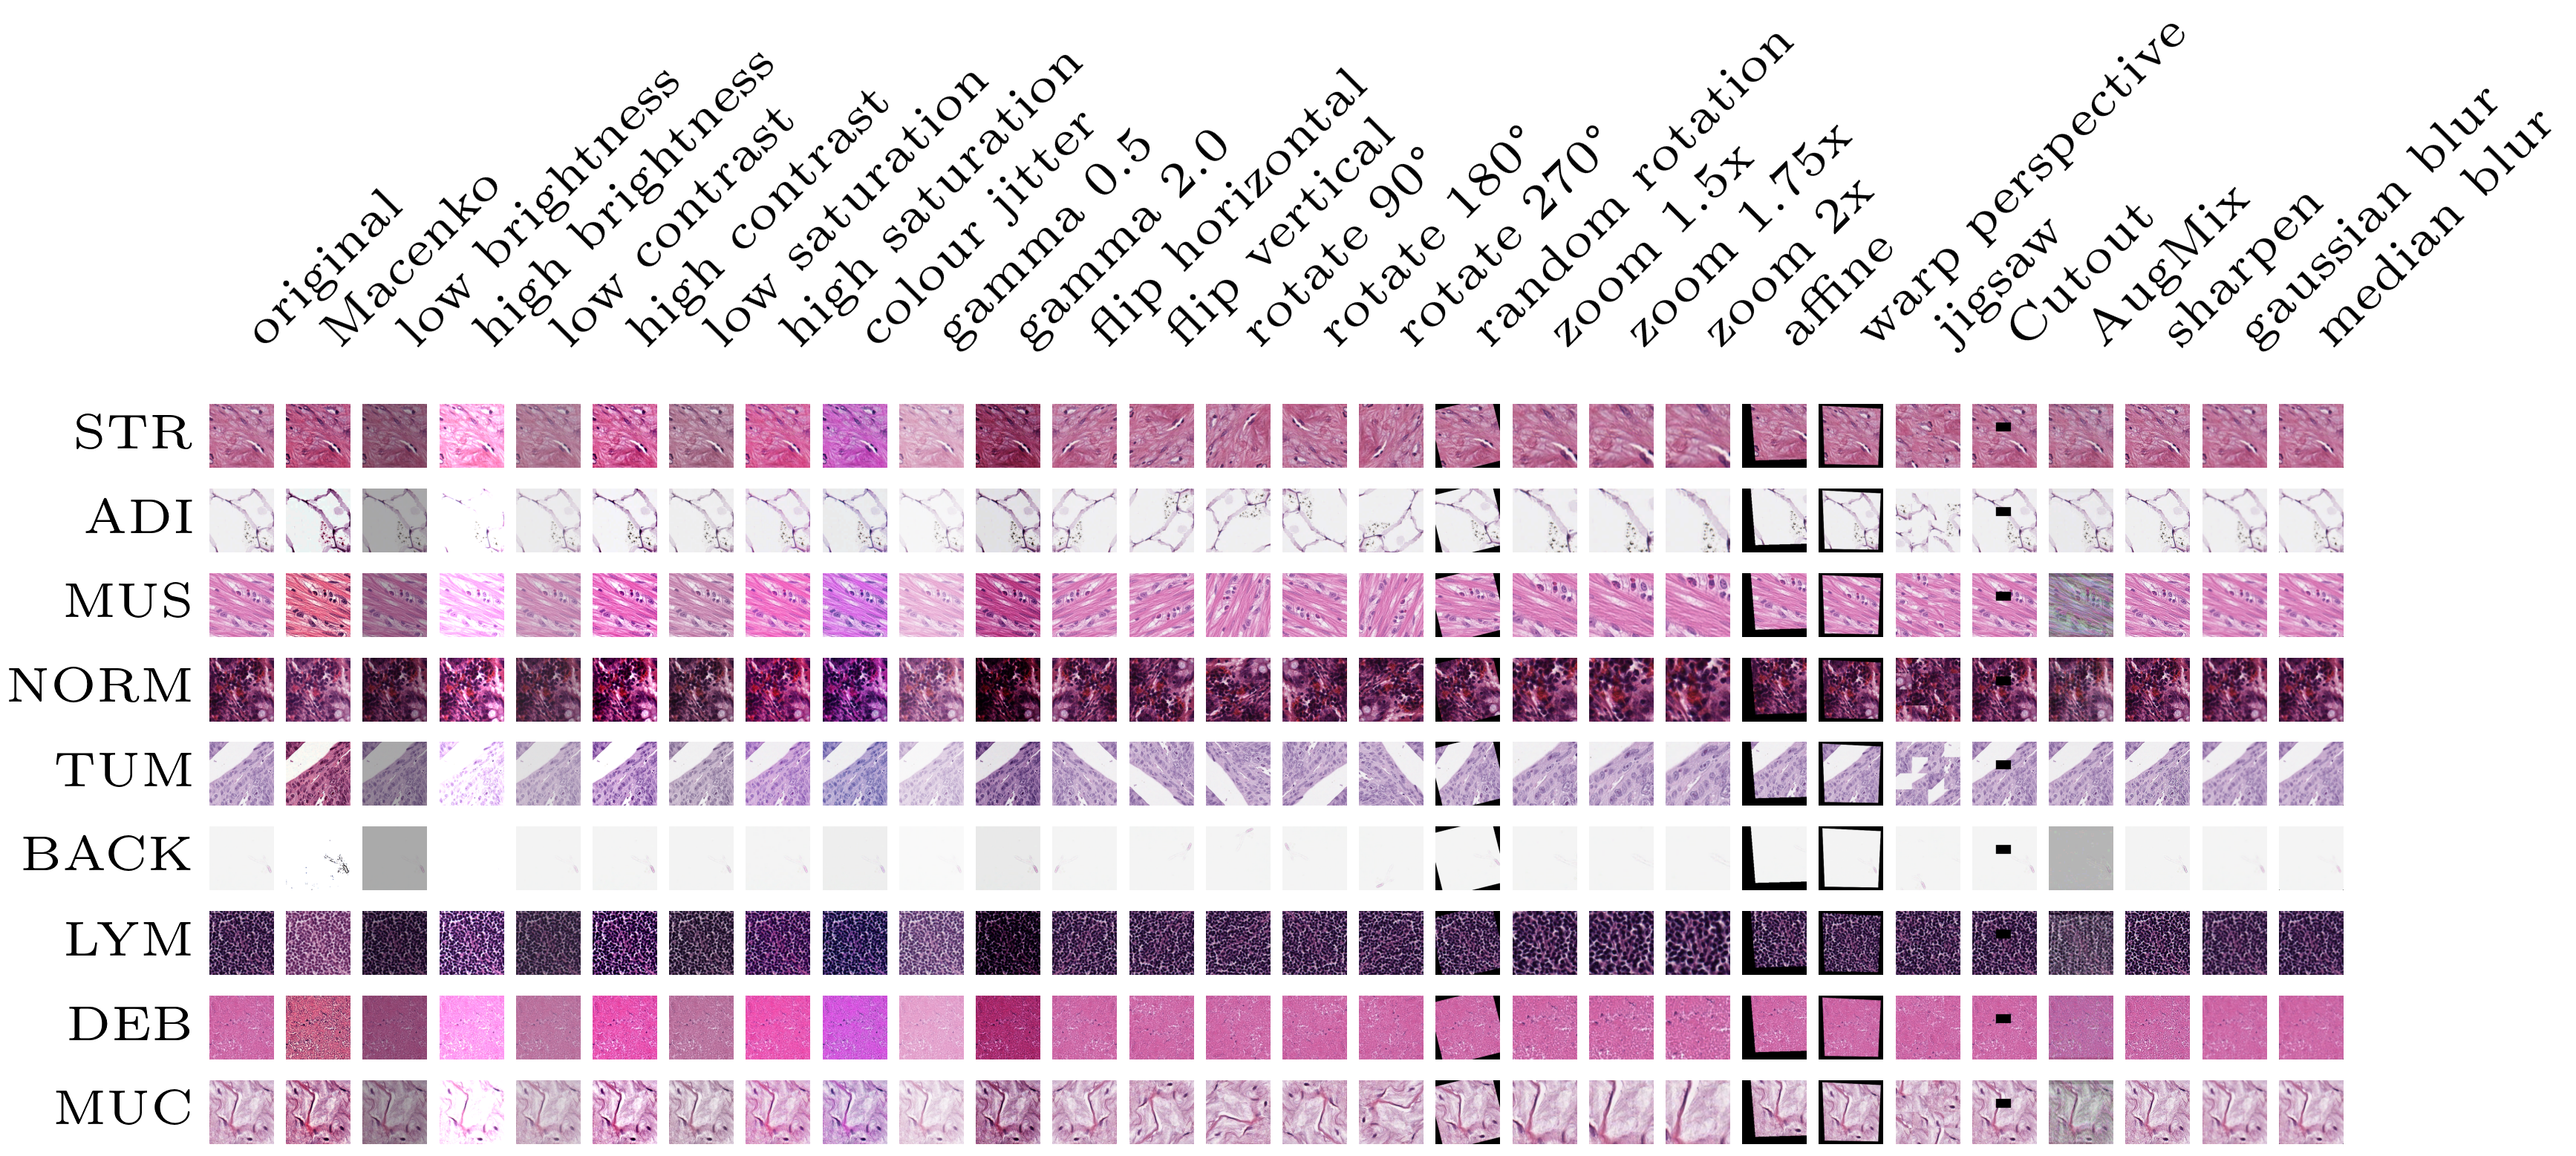

In [11]:
with rc_context(default_smaller=3, h=1.1):
    imgs = torch.stack(list(examples.values()))
    labels = list(examples.keys())
    image_fn = ds.inverse_transform
    device = "cuda:0"

    imgs = imgs.to(device)
    augmentations.to(device)

    with torch.no_grad():
        aug_imgs = {aug_name: aug(imgs) for aug_name, aug in augmentations.items()}

    n_imgs = len(imgs)
    n_augs = len(augmentations)

    # fig, axs = plt.subplots(n_imgs, n_augs + 2, figsize=(n_augs, n_imgs))
    fig, axs = plt.subplots(n_imgs, n_augs + 2)

    title_kwargs = dict(rotation=45, ha="left", va="bottom")

    for i, (ax_row, img, label) in enumerate(zip(axs, imgs, labels)):
        ax_label, ax_orig, *ax_augs = ax_row

        ax_label.text(1.0, 0.5, label, transform=ax_label.transAxes, ha="right", va="center")
        ax_label.axis("off")

        ax_orig.imshow(image_fn(img))
        ax_orig.axis("off")
        if i == 0:
            ax_orig.set_title("original", **title_kwargs)

        for ax_aug, (aug_name, augs) in zip(ax_augs, aug_imgs.items()):
            ax_aug.imshow(image_fn(augs[i]))
            ax_aug.axis("off")
            if i == 0:
                ax_aug.set_title(RENAME_AUGMENTATIONS.get(aug_name, aug_name), **title_kwargs)

    # fig.suptitle("Augmentations")

    savefig("augmentations", journal=JOURNAL)

    plt.show()